In [1]:
from Models.models.present_fc import PresentSimple
from Implementation.dataset import Dataset_anomaly_detection

/anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

## Preprocessing

In [35]:
import pandas as pd
import numpy as np
from Preprocessing import utils

### Data pipline 1

In [3]:
def data_pipline(data):
    '''
    Argument:
        data {pandas DataFrame}-- raw dataset

    Returns:
        data {pandas DataFrame}-- without CHMON, sorted and alarm-renamed dataset
    '''

    # drop CHMON, NMCMON
    data = data[~data['meta_facility'].isin(['CHMON', 'NMCMON'])]
    data = data.drop_duplicates(subset=['meta_nhpId', 'pk_timestamp'], keep='first')
    data = data.set_index(['meta_nhpId', 'pk_timestamp']).sort_index().reset_index()
    data.category = data.category.str.replace(" unplanned", '')
    data.category = data.category.str.replace(" planned", '')
    return data

### Data pipline 2, 4 steps, Restricting the the definition of `Normal`

#### Unavailable = UAS* > 8640 || *OPINAVG < 30 || * OPRAVG < 30 
#### alarm = alarm && ～Unavailable
#### Normal = No alarm

In [4]:
def anomaly_detection_pipline_new_rule(data):
    # convert to datetime
    data['pk_timestamp'] = pd.to_datetime(data['pk_timestamp'])
    # Step 1: Drop data before this date
    data = data[data['pk_timestamp'] > pd.to_datetime('2018-12-25')]
    # Step 2: Drop all NaN rows
    feature_names = [col for col in data.columns if
                     'pk_' not in col and 'meta_' not in col and 'alarm' not in col and 'category' not in col]
    data = data.dropna(axis=0, how='all', subset=feature_names)
    # Step 3: One-Hot encode the alarms
    data = utils.one_hot_encode_alarms(data)
    # Step 4: if it's normal and any UAS is greater than threshold, drop
    threshold = 8640
    uas_features = [col for col in data.columns if 'UAS' in col]
    uas_mask = data[uas_features].ge(threshold).any(axis=1)

    # New Rule, if OPINAVG
    op_features = [col for col in data.columns if 'OPRAVG' in col] + [col for col in data.columns if
                                                                      'OPINAVG' in col]
    op_features.remove('OPOUTAVG-OTS_OPINAVG-OTS_-')

    op_mask = data[op_features].le(-30).any(axis=1)

    mask = np.array(uas_mask) | np.array(op_mask)
    # drop Unavailable
    data = data[~mask]

    # All PM: 211 features
    alarm_names = [col for col in data.columns if 'alarm ' in col]
    X = data[feature_names]
    y = data[alarm_names]
    dev = data['meta_facility']
    return X, y, dev

In [36]:
data = pd.read_parquet(
    '/Users/sunjincheng/Desktop/Hackathon/data/hackathon/colt_london_1DAY_allPMs_pivoted_processed_anonymized_20191002.parquet')
data = data.drop(columns=['__index_level_0__'])
data = data_pipline(data)
X, y, dev = anomaly_detection_pipline_new_rule(data)

computing one-hot-encoded alarms


/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/sunjincheng/Desktop/Hackathon/Preprocessing/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_alarms.drop_duplicates(inplace=True)


preparing dataframe for merging with one-hot-encoded alarms
adding one-hot-encoded alarms to dataframe


### create dataset

In [37]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# scaler and encoders
feature_scaler = MinMaxScaler()
facility_onehot_encoder = OneHotEncoder()

# meta_facility
meta_facility = np.array(['OPTMON', 'WAN', 'ETH10G', 'OTM2', 'AMP', 'OTM4', 'FLEX', 'OSC', 'OTM0',
       'PTP', 'ODUCTP', 'ETH100G', 'ETTP', 'OTUTTP', 'NMCMON', 'RAMAN',
       'OC192', 'ETH', 'ODUTTP', 'OTMC2', 'ETH40G', 'OTMFLEX', 'OTM1', 'ODU0',
       'OTM3', 'OTDRCFG', 'STTP', 'ODU1', 'OC12', 'ODUFLEX', 'OC48'])
# fit and transform
X = feature_scaler.fit_transform(X)
facility_onehot_encoder.fit(meta_facility.reshape(-1,1))
dev = facility_onehot_encoder.transform(dev.to_frame()).toarray()

# fill na with 0
X[np.isnan(X)] = 0

# create label, for binary anomaly detection
y = 1 - y['alarm None']
y = y.astype(int)
y = np.expand_dims(y, -1)

# split dataset
X_train, X_test = train_test_split(X, test_size=0.2, random_state=12)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=12)
dev_train, dev_test = train_test_split(dev, test_size=0.2, random_state=12)



/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:353: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:354: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [38]:
import collections as cl
cl.Counter(y.flatten())

Counter({0: 2710509, 1: 7331})

In [39]:
# # save - use numpy.save
np.save('data/allpm_anomaly/X_train.npy',X_train)
np.save('data/allpm_anomaly/X_test.npy',X_test)
np.save('data/allpm_anomaly/y_train.npy',y_train)
np.save('data/allpm_anomaly/y_test.npy',y_test)
np.save('data/allpm_anomaly/dev_train.npy',dev_train)
np.save('data/allpm_anomaly/dev_test.npy',dev_test)

### A simple 2-layers fully connected neural network and colt all pm data

#### All facilities and all alarms masked as 1

In [11]:
model = PresentSimple('Implementation/models/', 'Implementation/logs', input_dim=211, num_classes=1, encode_dim=64, dev_num=31, batch_size=1000,
                  lr=0.001, regression=True, threshold=0.9, max_to_keep=50)
dataset = Dataset_anomaly_detection('data/allpm_anomaly/')

### init and train

In [12]:
model.initialize_variables()
model.train(dataset)

train_loss= 18.482485    train_acc= 0.998          round10
train_loss= 16.480103    train_acc= 0.994          round20
train_loss= 12.964671    train_acc= 0.998          round30
train_loss= 10.859539    train_acc= 0.998          round40
train_loss= 9.424663    train_acc= 0.997          round50
train_loss= 7.4513636    train_acc= 0.999          round60
train_loss= 6.510365    train_acc= 0.998          round70
train_loss= 5.6473527    train_acc= 0.998          round80
train_loss= 5.027205    train_acc= 0.997          round90
train_loss= 4.297921    train_acc= 0.997          round100
val_loss= 4.0930147    val_acc= 0.9978          round: 100
train_loss= 3.8018637    train_acc= 0.997          round110
train_loss= 3.619828    train_acc= 0.995          round120
train_loss= 2.6239536    train_acc= 0.999          round130
train_loss= 2.4826183    train_acc= 0.998          round140
train_loss= 2.8639927    train_acc= 0.995          round150
train_loss= 1.6785495    train_acc= 0.999          roun

train_loss= 0.8446195    train_acc= 0.999          round1280
train_loss= 1.091574    train_acc= 0.997          round1290
train_loss= 1.1515889    train_acc= 0.998          round1300
val_loss= 1.1663127    val_acc= 0.9978          round: 1300
train_loss= 1.8528478    train_acc= 0.995          round1310
train_loss= 1.8049877    train_acc= 0.994          round1320
train_loss= 1.16073    train_acc= 0.997          round1330
train_loss= 1.3382522    train_acc= 0.997          round1340
train_loss= 0.56938076    train_acc= 1.0          round1350
train_loss= 1.0815594    train_acc= 0.998          round1360
train_loss= 1.1086226    train_acc= 0.998          round1370
train_loss= 1.2603362    train_acc= 0.997          round1380
train_loss= 2.005016    train_acc= 0.996          round1390
train_loss= 1.2995603    train_acc= 0.997          round1400
val_loss= 1.072345    val_acc= 0.9978          round: 1400
train_loss= 1.0905042    train_acc= 0.997          round1410
train_loss= 0.77619135    train_

val_loss= 1.0727245    val_acc= 0.9978          round: 2500
train_loss= 2.176152    train_acc= 0.991          round2510
train_loss= 0.7721438    train_acc= 0.999          round2520
train_loss= 0.86095953    train_acc= 0.999          round2530
train_loss= 1.2002093    train_acc= 0.997          round2540
train_loss= 0.54106987    train_acc= 1.0          round2550
train_loss= 0.9431491    train_acc= 0.998          round2560
train_loss= 1.2709544    train_acc= 0.997          round2570
train_loss= 1.1820974    train_acc= 0.998          round2580
train_loss= 1.1448061    train_acc= 0.997          round2590
train_loss= 1.4634762    train_acc= 0.997          round2600
val_loss= 1.0676239    val_acc= 0.9978          round: 2600
train_loss= 0.8499841    train_acc= 0.999          round2610
train_loss= 1.6329973    train_acc= 0.994          round2620
train_loss= 0.9787191    train_acc= 0.998          round2630
train_loss= 0.9126456    train_acc= 0.998          round2640
train_loss= 1.1756418    tr

train_loss= 0.697575    train_acc= 1.0          round3750
train_loss= 0.6795056    train_acc= 0.999          round3760
train_loss= 0.96578723    train_acc= 0.999          round3770
train_loss= 1.5542691    train_acc= 0.995          round3780
train_loss= 0.91035974    train_acc= 0.998          round3790
train_loss= 1.1536698    train_acc= 0.997          round3800
val_loss= 1.0644644    val_acc= 0.9978          round: 3800
train_loss= 0.7475543    train_acc= 0.999          round3810
train_loss= 0.94391143    train_acc= 0.998          round3820
train_loss= 1.0213236    train_acc= 0.998          round3830
train_loss= 1.7808201    train_acc= 0.994          round3840
train_loss= 0.8671855    train_acc= 0.999          round3850
train_loss= 1.5563921    train_acc= 0.995          round3860
train_loss= 1.1275026    train_acc= 0.998          round3870
train_loss= 0.71658546    train_acc= 0.999          round3880
train_loss= 1.3681926    train_acc= 0.996          round3890
train_loss= 0.80709994  

train_loss= 0.81177163    train_acc= 0.999          round4980
train_loss= 1.4317248    train_acc= 0.996          round4990
train_loss= 1.1033399    train_acc= 0.999          round5000
val_loss= 1.0500441    val_acc= 0.9978          round: 5000
train_loss= 1.3568039    train_acc= 0.997          round5010
train_loss= 1.174831    train_acc= 0.996          round5020
train_loss= 1.3846153    train_acc= 0.996          round5030
train_loss= 1.0262113    train_acc= 0.998          round5040
train_loss= 0.49037793    train_acc= 1.0          round5050
train_loss= 1.1049744    train_acc= 0.997          round5060
train_loss= 1.900519    train_acc= 0.993          round5070
train_loss= 0.7923163    train_acc= 0.999          round5080
train_loss= 0.8518987    train_acc= 0.998          round5090
train_loss= 0.902138    train_acc= 0.999          round5100
val_loss= 1.0882051    val_acc= 0.9978          round: 5100
train_loss= 1.0012099    train_acc= 0.998          round5110
train_loss= 0.76127416    tra

val_loss= 1.0846281    val_acc= 0.9978          round: 6200
train_loss= 0.6570571    train_acc= 1.0          round6210
train_loss= 1.5629892    train_acc= 0.996          round6220
train_loss= 1.531637    train_acc= 0.996          round6230
train_loss= 1.5752316    train_acc= 0.997          round6240
train_loss= 0.76277274    train_acc= 0.999          round6250
train_loss= 1.5729948    train_acc= 0.996          round6260
train_loss= 0.8960861    train_acc= 0.998          round6270
train_loss= 1.391872    train_acc= 0.996          round6280
train_loss= 1.1465508    train_acc= 0.997          round6290
train_loss= 1.290091    train_acc= 0.996          round6300
val_loss= 1.166563    val_acc= 0.9979          round: 6300
train_loss= 1.0946629    train_acc= 0.998          round6310
train_loss= 1.7921495    train_acc= 0.992          round6320
train_loss= 1.4813347    train_acc= 0.996          round6330
train_loss= 1.0435227    train_acc= 0.998          round6340
train_loss= 1.0146823    train_

train_loss= 1.0156401    train_acc= 0.998          round7450
train_loss= 1.8110863    train_acc= 0.993          round7460
train_loss= 1.5769904    train_acc= 0.996          round7470
train_loss= 1.1473157    train_acc= 0.997          round7480
train_loss= 1.4448835    train_acc= 0.995          round7490
train_loss= 0.901709    train_acc= 0.998          round7500
val_loss= 1.0565112    val_acc= 0.9978          round: 7500
train_loss= 1.3217077    train_acc= 0.996          round7510
train_loss= 1.4617671    train_acc= 0.996          round7520
train_loss= 1.6129053    train_acc= 0.994          round7530
train_loss= 1.2493969    train_acc= 0.996          round7540
train_loss= 1.0506302    train_acc= 0.997          round7550
train_loss= 0.99216974    train_acc= 0.998          round7560
train_loss= 0.6876997    train_acc= 0.999          round7570
train_loss= 1.0138328    train_acc= 0.999          round7580
train_loss= 0.7914939    train_acc= 0.999          round7590
train_loss= 1.6240423    

## Restore checkpoint and evaluate

In [13]:
model.restore_checkpoint(3500)
proba = model.get_proba(dataset.test_set)

INFO:tensorflow:Restoring parameters from Implementation/models/-3500


In [14]:
from Evaluation.results import results, precision_recall, plot_pr_curve, auc_roc, plot_roc_curve

### apply a threshold to divide alarm and normal

In [33]:
def cut(data, threshold):
    data = data >= threshold
    data = data.astype(int)
    return data

prediction = cut(proba, 0.5)

### get the results

In [34]:
# results
hackathon_format = results(dataset.test_set['y'], prediction)
hackathon_format

,num examples,num alarms,num_alarms_correct,num pos predictions,precision,recall
0,543568,1498,1049,83578,0.012551,0.700267


### plot roc curve

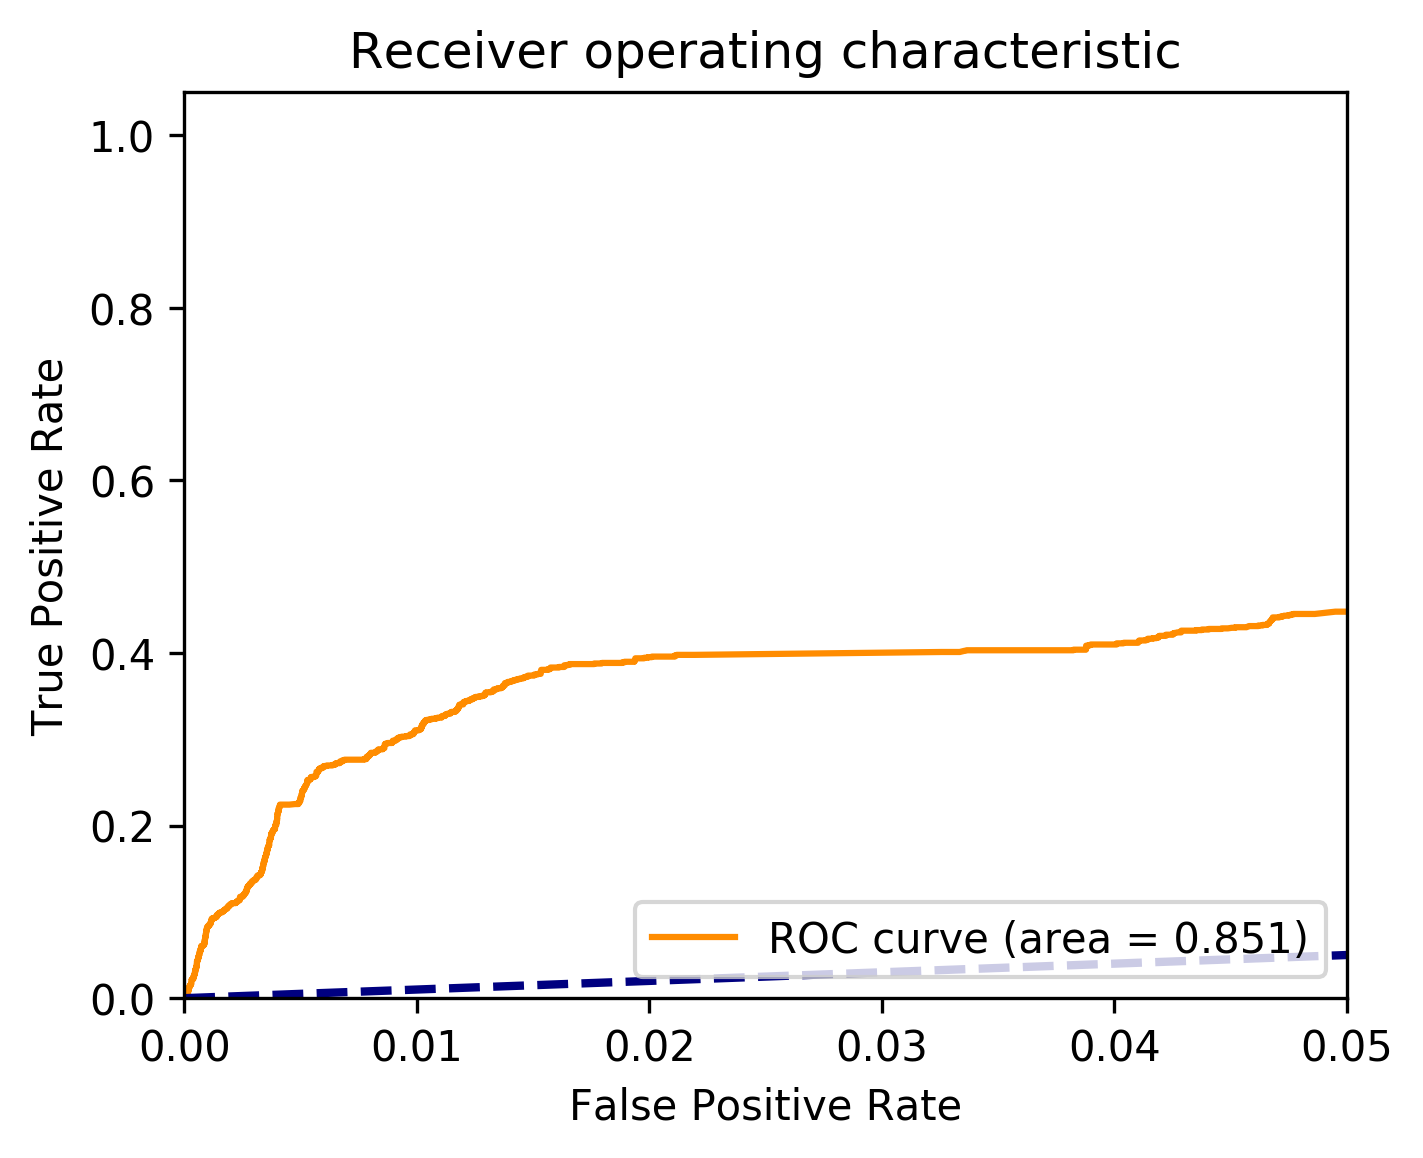

In [29]:
# plot roc curve
auc, fprs, tprs, thresholds = auc_roc(y_pred=proba, y_test=dataset.test_set['y'])

plot_roc_curve(fprs, tprs, auc, x_axis=0.05)

### plot precision recall curve

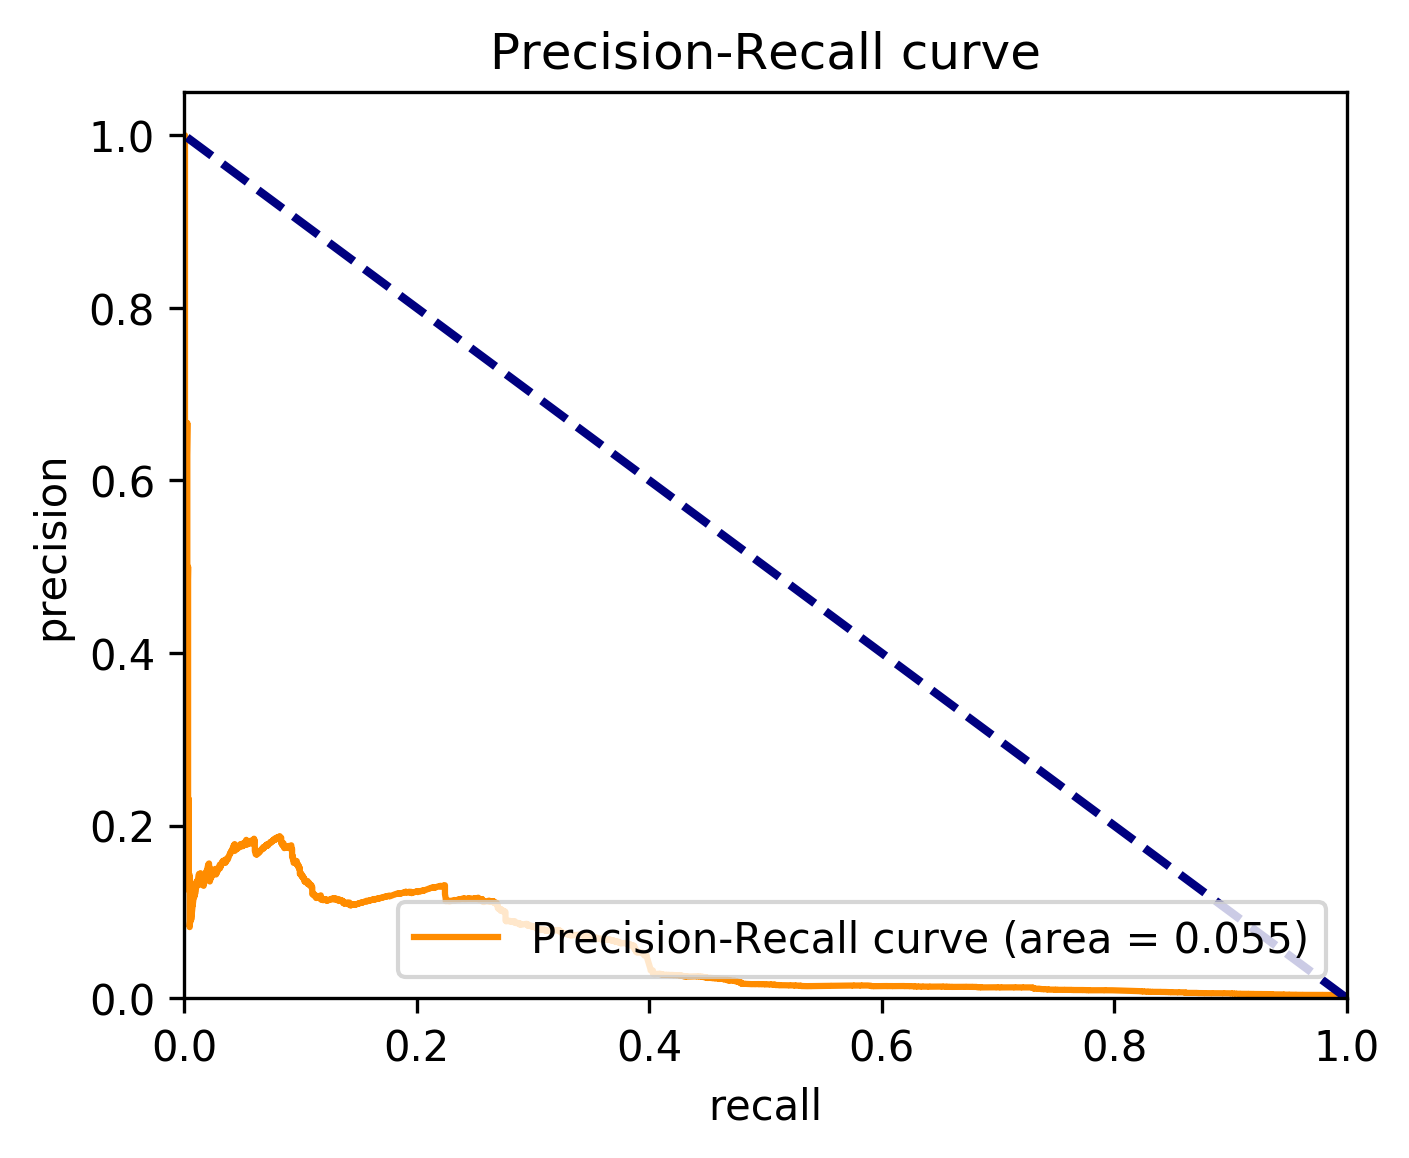

In [30]:
# plot precision recall curve
auc, precisions, recalls, thresholds = precision_recall(y_pred=proba, y_test=dataset.test_set['y'])

plot_pr_curve(recalls, precisions, auc)